<a href="https://colab.research.google.com/github/KondrashovIgor/wrongTransportSchemeCheckforCDEK/blob/main/NLP_with_ML_processing_on_a_films_genre_classification_Kondrashov_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jrobischon_wikipedia_movie_plots_path = kagglehub.dataset_download('jrobischon/wikipedia-movie-plots')

print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#!pip uninstall numpy==1.26.4 -y #uncomment this for the first attempt to avoid compatibility problems. Comment after restart
#!pip install --force-reinstall numpy==1.18.5 #uncomment this for the first attempt to avoid compatibility problems. Comment back after restart
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#!pip install --force-reinstall gensim #uncomment this to avoid the compatibility problems, restart the session and return the comment hash at the start of the line
import gensim
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv


In [7]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.2
astropy-iers-data                     0.2025.5.12.0.38.29
astunparse                            1

In [3]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from nltk.stem import LancasterStemmer ##for cleaning
nltk.download('stopwords') #will drop errors w/o it
nltk.download('punkt_tab')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [5]:
data = pd.read_csv('/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv')
data.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [8]:
desc = pd.DataFrame(index = list(data))
desc['count'] = data.count()
desc['nunique'] = data.nunique()
desc['%unique'] = desc['nunique'] / len(data) * 100
desc['null'] = data.isnull().sum()
desc['%null'] = desc['null'] / len(data) * 100
desc['type'] = data.dtypes
desc = pd.concat([desc, data.describe().T.drop('count', axis = 1)], axis = 1)
desc

,count,nunique,%unique,null,%null,type,mean,std,min,25%,50%,75%,max
Release Year,34886,117,0.335378,0,0.000000,int64,1981.314252,27.815174,1901.0,1957.0,1988.0,2007.0,2017.0
Title,34886,32432,92.965660,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Origin/Ethnicity,34886,24,0.068796,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Director,34886,12593,36.097575,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cast,33464,32182,92.249040,1422,4.076134,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,34886,2265,6.492576,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wiki Page,34886,34070,97.660953,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plot,34886,33869,97.084790,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data['Genre'].value_counts()

,count
Genre,
unknown,6083
drama,5964
comedy,4379
horror,1167
action,1098
...,...
"drama, crime, thriller, sci-fi, action, spy",1
"horror, fantasy, action, magical girl, science fantasy, spy",1
"drama, sports (road bicycle racing), comedy-drama",1


In [10]:
df = data[data['Release Year']>1960]
df.shape

(24995, 8)

In [11]:
df['Genre'].value_counts(ascending=False).head(10)

,count
Genre,
unknown,5574
drama,3812
comedy,2806
action,1054
horror,1043
thriller,818
romance,787
crime drama,363
romantic comedy,309


In [12]:
movies = df.copy()
movies['GenreCorrected'] =movies['Genre']
movies['GenreCorrected']=movies['GenreCorrected'].str.strip()
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' - ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' / ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('/', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' & ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(', ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('; ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bio-pic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biopic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biographical', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biodrama', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bio-drama', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biographic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(film genre\)', '')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animated','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('anime','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('children\'s','children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedey','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[not in citation given\]','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' set 4,000 years ago in the canadian arctic','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historical','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romantic','romance')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('3-d','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('3d','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('viacom 18 motion pictures','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sci-fi','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('ttriller','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('.','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('based on radio serial','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' on the early years of hitler','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sci fi','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science fiction','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' (30min)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('16 mm film','short')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[140\]','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[144\]','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' for ','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventures','adventure')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('kung fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('kung-fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial arts','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('world war ii','war')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('world war i','war')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography about montreal canadiens star|maurice richard','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bholenath movies|cinekorn entertainment','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(volleyball\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('spy film','spy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('anthology film','anthology')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography fim','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('avant-garde','avant_garde')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biker film','biker')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('buddy cop','buddy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('buddy film','buddy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedy 2-reeler','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('films','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('film','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography of pioneering american photographer eadweard muybridge','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('british-german co-production','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bruceploitation','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedy-drama adaptation of the mordecai richler novel','comedy-drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movies by the mob\|knkspl','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movies','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movie','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('coming of age','coming_of_age')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('coming-of-age','coming_of_age')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('drama about child soldiers','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( based).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( co-produced).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( adapted).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( about).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('musical b','musical')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animationchildren','animation|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' period','period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('drama loosely','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("yogesh dattatraya gosavi's directorial debut \[9\]",'')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("war-time","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("wartime","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("ww1","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('unknown','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("wwii","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('psychological','psycho')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('rom-coms','romance')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('true crime','crime')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|007','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('slice of life','slice_of_life')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('computer animation','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('gun fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('j-horror','horror')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(shogi|chess\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('afghan war drama','war drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|6 separate stories','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(30min\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' (road bicycle racing)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' v-cinema','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('tv miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|docudrama','\|documentary|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' in animation','|animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adaptation).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adaptated).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adapted).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( on ).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('american football','sports')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dev\|nusrat jahan','sports')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('television miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(artistic\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \|direct-to-dvd','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('history dram','history drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial art','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('psycho thriller,','psycho thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|1 girl\|3 suitors','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(road bicycle racing\)','')
filterE = movies['GenreCorrected']=="ero"
movies.loc[filterE,'GenreCorrected']="adult"
filterE = movies['GenreCorrected']=="music"
movies.loc[filterE,'GenreCorrected']="musical"
filterE = movies['GenreCorrected']=="-"
movies.loc[filterE,'GenreCorrected']=''
filterE = movies['GenreCorrected']=="comedy–drama"
movies.loc[filterE,'GenreCorrected'] = "comedy|drama"
filterE = movies['GenreCorrected']=="comedy–horror"
movies.loc[filterE,'GenreCorrected'] = "comedy|horror"
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' ','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(',','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('-','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionadventure','action|adventure')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actioncomedy','action|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actiondrama','action|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionlove','action|love')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionmasala','action|masala')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionchildren','action|children')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasychildren\|','fantasy|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasycomedy','fantasy|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasyperiod','fantasy|period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('cbctv_miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramacomedy','drama|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramacomedysocial','drama|comedy|social')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramathriller','drama|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedydrama','comedy|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramathriller','drama|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedyhorror','comedy|horror')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sciencefiction','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventurecomedy','adventure|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animationdrama','animation|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\|','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('muslim','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('thriler','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('crimethriller','crime|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantay','fantasy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionthriller','action|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedysocial','comedy|social')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martialarts','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\(children\|poker\|karuta\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('epichistory','epic|history')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('erotica','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('erotic','adult')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((\|produced\|).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('chanbara','chambara')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedythriller','comedy|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biblical','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biblical','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('colour\|yellow\|productions\|eros\|international','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|directtodvd','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('liveaction','live|action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('melodrama','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superheroes','superheroe')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('gangsterthriller','gangster|thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('heistcomedy','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('heist','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historic','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historydisaster','history|disaster')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('warcomedy','war|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('westerncomedy','western|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('ancientcostume','costume')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('computeranimation','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramatic','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familya','family')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familya','family')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramedy','drama|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramaa','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('famil\|','family')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superheroe','superhero')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biogtaphy','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('devotionalbiography','devotional|biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('docufiction','documentary|fiction')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familydrama','family|drama')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('espionage','spy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('supeheroes','superhero')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancefiction','romance|fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('horrorthriller','horror|thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('suspensethriller','suspense|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('musicaliography','musical|biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('triller','thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\(fiction\)','|fiction')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romanceaction','romance|action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancecomedy','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancehorror','romance|horror')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romcom','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('rom\|com','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('satirical','satire')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science_fictionchildren','science_fiction|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('homosexual','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sexual','adult')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('mockumentary','documentary')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('periodic','period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romanctic','romantic')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('politics','political')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('samurai','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('tv_miniseries','series')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('serial','series')

filterE = movies['GenreCorrected']=="musical–comedy"
movies.loc[filterE,'GenreCorrected'] = "musical|comedy"

filterE = movies['GenreCorrected']=="roman|porno"
movies.loc[filterE,'GenreCorrected'] = "adult"


filterE = movies['GenreCorrected']=="action—masala"
movies.loc[filterE,'GenreCorrected'] = "action|masala"


filterE = movies['GenreCorrected']=="horror–thriller"
movies.loc[filterE,'GenreCorrected'] = "horror|thriller"

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('family','children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial_arts','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('horror','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('war','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventure','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science_fiction','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('western','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('western','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('noir','black')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('spy','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superhero','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('social','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('suspense','action')


filterE = movies['GenreCorrected']=="drama|romance|adult|children"
movies.loc[filterE,'GenreCorrected'] = "drama|romance|adult"

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|–\|','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.strip(to_strip='\|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionner','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.strip()

In [13]:
movies['GenreCorrected'].value_counts(ascending=False).head(50)

,count
GenreCorrected,
,5636
drama,3873
comedy,2834
action,2272
thriller,1891
romance,811
comedy|drama,415
romance|comedy,408
animation,405


In [14]:
pureGenresTop = (movies[~movies['GenreCorrected'].str.contains('\|')]['GenreCorrected'])

In [15]:
pureGenresTop.value_counts(ascending=False).head(50)

,count
GenreCorrected,
,5636
drama,3873
comedy,2834
action,2272
thriller,1891
romance,811
animation,405
children,217
crime,199


In [16]:
df = movies[movies['GenreCorrected'].isin(pureGenresTop.value_counts(ascending=False).head(6).index.tolist())]

In [17]:
df.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreCorrected
7440,1961,The Absent-Minded Professor,American,Robert Stevenson,"Fred MacMurray, Nancy Olson, Keenan Wynn, Tomm...",comedy,https://en.wikipedia.org/wiki/The_Absent-Minde...,Professor Brainard (Fred MacMurray) (pronounce...,comedy
7444,1961,Angel Baby,American,Paul Wendkos,"George Hamilton, Mercedes McCambridge, Joan Bl...",drama,https://en.wikipedia.org/wiki/Angel_Baby_(1961...,"In the rural American south, Angel Baby who ha...",drama
7446,1961,"Atlantis, the Lost Continent",American,George Pal,"John Dall, Edward Platt",sci-fi,"https://en.wikipedia.org/wiki/Atlantis,_the_Lo...",A Greek fisherman named Demetrios and his fath...,action
7448,1961,Bachelor in Paradise,American,Jack Arnold,"Bob Hope, Lana Turner, Paula Prentiss, Janis P...",comedy,https://en.wikipedia.org/wiki/Bachelor_in_Para...,A.J. Niles is a provocative best-selling autho...,comedy
7449,1961,Back Street,American,David Miller,"Susan Hayward, John Gavin, Vera Miles",drama,https://en.wikipedia.org/wiki/Back_Street_(196...,Wealthy department-store heir Paul Saxon has a...,drama
7450,1961,Battle at Bloody Beach,American,Herbert Coleman,"Audie Murphy, Dolores Michaels",war,https://en.wikipedia.org/wiki/Battle_at_Bloody...,Craig Benson (Audie Murphy) is a civilian work...,action
7451,1961,The Beast of Yucca Flats,American,Coleman Francis,Tor Johnson,sci-fi,https://en.wikipedia.org/wiki/The_Beast_of_Yuc...,A woman (Lanell Cado) steps out of a shower an...,action
7454,1961,The Big Gamble,American,Richard Fleischer,"Stephen Boyd, Juliette Greco, David Wayne",adventure,https://en.wikipedia.org/wiki/The_Big_Gamble_(...,Vic Brennan is a sailor from Dublin who decide...,action
7455,1961,The Big Show,American,James B. Clark,"Esther Williams, Cliff Robertson, Robert Vaughn",drama,https://en.wikipedia.org/wiki/The_Big_Show_(19...,Bruno Everhard (Persoff) is the rigid and unco...,drama
7456,1961,Blast of Silence,American,Allen Baron,"Allen Baron, Larry Tucker",thriller,https://en.wikipedia.org/wiki/Blast_of_Silence,"Frankie Bono, a hitman from Cleveland, comes t...",thriller


Continue if you want to check DECISION FORESTS and LSTM. Otherwise skip until the next TEXT block

In [ ]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') #won't work without it

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Rejoin tokens into a single string
    processed_text = ' '.join(tokens)

    return processed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df['Plot_cleaned'] = df['Plot'].apply(preprocess_text)

<ipython-input-18-a768433eb246>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Plot_cleaned'] = df['Plot'].apply(preprocess_text)


In [ ]:
df_unknown_genre = movies[movies['GenreCorrected']=='']

In [ ]:
df_train = df[df['GenreCorrected']!='']

In [ ]:
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

In [ ]:
encoder = LabelEncoder()

y = encoder.fit_transform(df_train['GenreCorrected'])

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(df_train,y,test_size=0.2,random_state=1)

In [ ]:
def train_word2vec_model(df):
    plot = []
    for doc in df['Plot_cleaned']:
        raw_sent = sent_tokenize(doc)
        for sent in raw_sent:
            plot.append(simple_preprocess(sent))

    model = gensim.models.Word2Vec(
        window=10,
        min_count=2
    )
    model.build_vocab(plot)
    model.train(plot, total_examples=model.corpus_count, epochs=100)

    return model
w2v_model = train_word2vec_model(X_train)

In [ ]:
from tqdm import tqdm
def document_vector(doc, model):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    if not doc:
        # If no words are in the vocabulary, return zeros
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

X_train_embd = []
for doc in tqdm(X_train['Plot_cleaned'].values):
    X_train_embd.append(document_vector(doc, w2v_model))
X_train_embd = np.array(X_train_embd)

X_val_embd = []
for doc in tqdm(X_val['Plot_cleaned'].values):
    X_val_embd.append(document_vector(doc, w2v_model))
X_val_embd = np.array(X_val_embd)

100%|██████████| 2337/2337 [01:35<00:00, 24.59it/s]


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_embd,y_train)
y_pred = rf.predict(X_val_embd)
accuracy_score(y_val,y_pred)

0.5836542575952075

In [ ]:
predicted_labels = encoder.inverse_transform(y_pred)
predicted_df = pd.DataFrame({'Predicted_Genre': predicted_labels})
predicted_df.value_counts()

,count
Predicted_Genre,
drama,987
comedy,521
action,469
thriller,293
romance,67


In [ ]:
def predict_genre(input_text, w2v_model, classifier, encoder,model_type='rf',clean_text=True):
    if clean_text:
        input_text = preprocess_text(input_text)
    input_vector = document_vector(input_text, w2v_model)
    input_vector = input_vector.reshape(1, -1)
    if model_type == 'rf':
        prediction = classifier.predict(input_vector)
        predicted_genre = encoder.inverse_transform(prediction)[0]
    else:
        prediction = classifier.predict(input_vector,verbose=0)
        predicted_class_index = prediction.argmax(axis=-1)
        predicted_genre = encoder.inverse_transform(predicted_class_index)[0]
    return predicted_genre

In [ ]:
user_input = "In a quirky small town, an eccentric inventor accidentally creates a device that swaps personalities. Hilarity ensues as the entire community undergoes unexpected transformations. Chaos reigns as the town's shy librarian becomes a stand-up comedian, the mayor turns into a rockstar, and the local baker becomes a fearless crime fighter."
predicted_genre = predict_genre(user_input, w2v_model, rf, encoder)
print("Predicted Genre:", predicted_genre)

Predicted Genre: comedy


In [ ]:
df_unkonwn_genre_sample = df_unknown_genre.sample(500)
predictions_test = []

for doc in tqdm(df_unkonwn_genre_sample['Plot'].values):
    predicted_genre = predict_genre(doc, w2v_model, rf, encoder,clean_text=False)
    predictions_test.append(predicted_genre)

# Create a new DataFrame with the predictions
df_unkonwn_genre_sample['Predicted_Genre_rf'] = predictions_test

100%|██████████| 500/500 [02:33<00:00,  3.26it/s]


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, BatchNormalization
from keras.callbacks import EarlyStopping
import torch

In [ ]:
df_train['GenreCorrected'].value_counts()

,count
GenreCorrected,
drama,3873
comedy,2834
action,2272
thriller,1891
romance,811


In [ ]:
# was getting some error about negative values in embeddings while fitting lstm model that's why did this
X_train_embd2 = X_train_embd
X_val_embd2 = X_val_embd

In [ ]:
X_val_embd2

array([[2.6210217, 2.6593466, 2.0721595, ..., 3.5868459, 4.1363735,
        3.3410263],
       [2.4858508, 2.9054701, 2.6272578, ..., 3.7254262, 3.2232213,
        3.4740908],
       [2.9031117, 2.4302344, 3.2724342, ..., 3.0483325, 3.221011 ,
        3.2607887],
       ...,
       [2.737577 , 1.9815825, 3.1138825, ..., 3.4761708, 3.044486 ,
        3.3615894],
       [2.5379777, 2.6842644, 2.4679298, ..., 3.2702425, 3.7134044,
        3.2509036],
       [3.0479736, 2.776067 , 2.7391691, ..., 2.72318  , 3.642426 ,
        3.4374504]], dtype=float32)

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=50)
#optimizer=keras.optimizers.Adam(learning_rate=1e-2) Somehow turns all predictions into 'drama', needs complete adjustment!

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=100, output_dim=100))
model_lstm.add(LSTM(100, dropout=0.3,activation='tanh'))
# model_lstm.add(BatchNormalization())
model_lstm.add(Dense(len(encoder.classes_), activation='softmax'))
optimizer = keras.optimizers.Adafactor(learning_rate=1e-3)
# Compile the model with a lower learning rate
model_lstm.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_lstm.fit(X_train_embd2, y_train, epochs=50, batch_size=64, validation_data=(X_val_embd2, y_val),
                         callbacks=[callback])

# Evaluate the model on the test set
test_loss, test_accuracy = model_lstm.evaluate(X_val_embd2, y_val)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 30s 177ms/step - accuracy: 0.3108 - loss: 1.5698 - val_accuracy: 0.3188 - val_loss: 1.5158
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - accuracy: 0.3428 - loss: 1.4978 - val_accuracy: 0.3188 - val_loss: 1.5121
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 179ms/step - accuracy: 0.3364 - loss: 1.5037 - val_accuracy: 0.3188 - val_loss: 1.5117
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.3396 - loss: 1.4922 - val_accuracy: 0.3188 - val_loss: 1.5077
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 184ms/step - accuracy: 0.3353 - loss: 1.4959 - val_accuracy: 0.3188 - val_loss: 1.5050
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.3338 - loss: 1.4944 - val_accuracy: 0.3188 - val_loss: 1.5018
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.3362 - loss: 1.4953 - val_accuracy: 0.3184 - val_loss: 1.4948
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.3411 - loss: 1

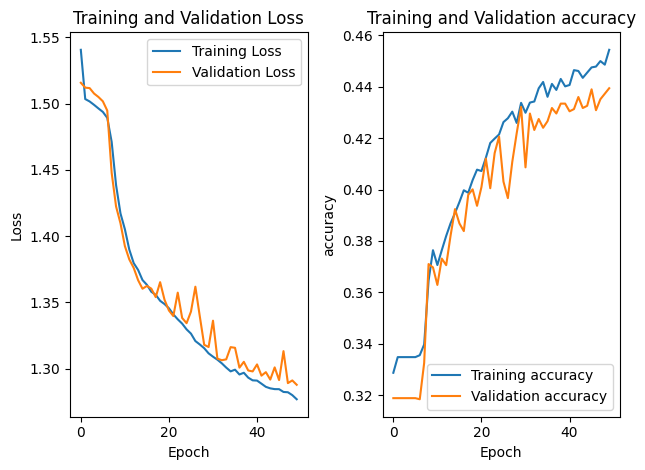

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
predictions_test_lstm = []

for doc in tqdm(df_unkonwn_genre_sample['Plot'].values):
    predicted_genre = predict_genre(user_input, w2v_model, model_lstm, encoder,model_type='lstm',clean_text=False)
    predictions_test_lstm.append(predicted_genre)

# Create a new DataFrame with the predictions
df_unkonwn_genre_sample['Predicted_Genre_lstm'] = predictions_test_lstm

100%|██████████| 500/500 [01:33<00:00,  5.37it/s]


In [ ]:
df_unkonwn_genre_sample[['Predicted_Genre_lstm']].value_counts()

,count
Predicted_Genre_lstm,
thriller,500


Alternative approach with SVC method. Continuation for the SVC block

In [18]:
df.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreCorrected
7440,1961,The Absent-Minded Professor,American,Robert Stevenson,"Fred MacMurray, Nancy Olson, Keenan Wynn, Tomm...",comedy,https://en.wikipedia.org/wiki/The_Absent-Minde...,Professor Brainard (Fred MacMurray) (pronounce...,comedy
7444,1961,Angel Baby,American,Paul Wendkos,"George Hamilton, Mercedes McCambridge, Joan Bl...",drama,https://en.wikipedia.org/wiki/Angel_Baby_(1961...,"In the rural American south, Angel Baby who ha...",drama
7446,1961,"Atlantis, the Lost Continent",American,George Pal,"John Dall, Edward Platt",sci-fi,"https://en.wikipedia.org/wiki/Atlantis,_the_Lo...",A Greek fisherman named Demetrios and his fath...,action
7448,1961,Bachelor in Paradise,American,Jack Arnold,"Bob Hope, Lana Turner, Paula Prentiss, Janis P...",comedy,https://en.wikipedia.org/wiki/Bachelor_in_Para...,A.J. Niles is a provocative best-selling autho...,comedy
7449,1961,Back Street,American,David Miller,"Susan Hayward, John Gavin, Vera Miles",drama,https://en.wikipedia.org/wiki/Back_Street_(196...,Wealthy department-store heir Paul Saxon has a...,drama
7450,1961,Battle at Bloody Beach,American,Herbert Coleman,"Audie Murphy, Dolores Michaels",war,https://en.wikipedia.org/wiki/Battle_at_Bloody...,Craig Benson (Audie Murphy) is a civilian work...,action
7451,1961,The Beast of Yucca Flats,American,Coleman Francis,Tor Johnson,sci-fi,https://en.wikipedia.org/wiki/The_Beast_of_Yuc...,A woman (Lanell Cado) steps out of a shower an...,action
7454,1961,The Big Gamble,American,Richard Fleischer,"Stephen Boyd, Juliette Greco, David Wayne",adventure,https://en.wikipedia.org/wiki/The_Big_Gamble_(...,Vic Brennan is a sailor from Dublin who decide...,action
7455,1961,The Big Show,American,James B. Clark,"Esther Williams, Cliff Robertson, Robert Vaughn",drama,https://en.wikipedia.org/wiki/The_Big_Show_(19...,Bruno Everhard (Persoff) is the rigid and unco...,drama
7456,1961,Blast of Silence,American,Allen Baron,"Allen Baron, Larry Tucker",thriller,https://en.wikipedia.org/wiki/Blast_of_Silence,"Frankie Bono, a hitman from Cleveland, comes t...",thriller


In [24]:
from nltk.stem import LancasterStemmer ##for cleaning
nltk.download('stopwords') #will drop errors w/o it
nltk.download('punkt_tab')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


stemmer = LancasterStemmer()
stop_words = set(stopwords.words("english"))  # Stopwords set

def cleaning_data(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'.pic\S+', '', text)
    text = re.sub(r'[^a-zA-Z+]', ' ', text)  # Change to replace non-characters with a space
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    # Use the predefined stop_words variable instead of redefining it inside the function
    text = " ".join([i for i in words if i not in stop_words and len(i) > 2])
    text = re.sub(r"\s+", " ", text).strip()  # Replace multiple spaces with a single space
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [28]:
df_trainSVC = df[df['GenreCorrected']!='']

In [29]:
df['Plot_cleaned_svc'] = df_trainSVC['Plot'].apply(cleaning_data)

<ipython-input-29-27922c3e714d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Plot_cleaned_svc'] = df_trainSVC['Plot'].apply(cleaning_data)


In [30]:
encoder = LabelEncoder()

y = encoder.fit_transform(df_trainSVC['GenreCorrected'])

In [45]:
vectorize = TfidfVectorizer()

df_trainSVC = vectorize.fit_transform(df_trainSVC["Plot_cleaned_svc"])

In [47]:
X_train,X_val,y_train,y_val = train_test_split(df_trainSVC,y,test_size=0.2,random_state=1)

In [48]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 447, 1: 583, 2: 745, 3: 165, 4: 397}

In [49]:
model = SVC()
model.fit(X_train, y_train)

SVC()

In [50]:
model.score(X_train, y_train)

0.9830907534246576

In [52]:
y_pred = model.predict(X_val)
y_pred

array([1, 1, 2, ..., 1, 2, 4])

In [53]:
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5742404792468977
